In [77]:
import sys
sys.path.append("../")

In [78]:
import pandas as pd
import datetime as dt
import plotly.graph_objects as go
#our functions/files we created
from technicals.indicators import RSI
from technicals.patterns import apply_patterns
from plotting import CandlePlot

In [79]:
df_raw = pd.read_pickle("../data/EUR_USD_H1.pkl") #random pair we are using 

In [80]:
df_raw.shape

(37216, 14)

In [81]:
df_an = df_raw.iloc[-6000:].copy()  #create a copy of last 6000 candles 
#df_an.reset_index(drop=True, inplace=True)

In [82]:
df_an.shape

(6000, 14)

In [83]:
df_an = RSI(df_an)

In [84]:
df_an.tail() #RSI is none value since our wins and losses rsi stuff we dont 
#specify index value but we just put them onto dataframe
#need to resrt index back to 0
df_an.reset_index(drop=True, inplace=True)

In [85]:
df_an = apply_patterns(df_an)

In [86]:
df_an['EMA_200'] = df_an.mid_c.ewm(span=200, min_periods=200).mean()
#we wnat mid close price and we specficy the ema of 200

In [87]:
df_an.columns #we dont need all of cols only need subset

Index(['time', 'volume', 'mid_o', 'mid_h', 'mid_l', 'mid_c', 'bid_o', 'bid_h',
       'bid_l', 'bid_c', 'ask_o', 'ask_h', 'ask_l', 'ask_c', 'RSI_14',
       'body_lower', 'body_upper', 'body_bottom_perc', 'body_top_perc',
       'body_perc', 'direction', 'body_size', 'low_change', 'high_change',
       'body_size_change', 'mid_point', 'mid_point_prev_2', 'body_size_prev',
       'direction_prev', 'direction_prev_2', 'body_perc_prev',
       'body_perc_prev_2', 'HANGING_MAN', 'SHOOTING_STAR', 'SPINNING_TOP',
       'MARUBOZU', 'ENGULFING', 'TWEEZER_TOP', 'TWEEZER_BOTTOM',
       'MORNING_STAR', 'EVENING_STAR', 'EMA_200'],
      dtype='object')

In [88]:
our_cols = ['time', 'mid_o', 'mid_h', 'mid_l', 'mid_c',
                'ask_c','bid_c', 'ENGULFING', 'direction', 'EMA_200', 'RSI_14' ]

In [89]:
#since we dont need all cols we only want ^^ make a copy of dataframe
df_slim = df_an[our_cols].copy()  #make new df and send in our new cols
df_slim.dropna(inplace=True) #head is still causing an issue so we will remove all na values
df_slim.reset_index(drop=True, inplace=True) #resset the index to remoove na and resert index

In [90]:
df_slim.head()

,time,mid_o,mid_h,mid_l,mid_c,ask_c,bid_c,ENGULFING,direction,EMA_200,RSI_14


In [91]:
#apply signals if we want to place trade
#for buy low of mid must be above ema 200
#rsi must be above 50
#candle should be green and engulfing and oppsiute for sell
BUY = 1
SELL = -1
NONE = 0
RSI_LIMIT = 50.0


def apply_signal(row):
    #dont place trade unless its engulafing
    if row.ENGULFING == True:
        #are we placing buy or sell + it must be above EMA 200
        if row.direction == BUY and row.mid_l > row.EMA_200:
            #check if RSI is greater than RSI limit we set
            if row.RSI_14 > RSI_LIMIT:
                return BUY
        if row.direction == SELL and row.mid_h < row.EMA_200:
            if row.RSI_14 < RSI_LIMIT:
                return SELL
    return NONE        

In [92]:
#col called signal 
df_slim["SIGNAL"] = df_slim.apply(apply_signal, axis=1)

In [93]:
df_slim["SIGNAL"].value_counts() # how many of each type do we have

Series([], Name: count, dtype: int64)

In [94]:
LOSS_FACTOR = -1.0 #risk we are willining to take
PROFIT_FACTOR = 1.5 #reward we want to take
#we can change these values later^^

def apply_take_profit(row):
    #if we acutally have a buy or sell returned back from prev func
    if row.SIGNAL != NONE:
        #based on forumla we decided to follow 
        return (row.mid_c - row.mid_o) * 1.5 + row.mid_c
    else:
        return 0.0

def apply_stop_loss(row):
    if row.SIGNAL != NONE:
        #return open price
        return row.mid_o
    else:
        return 0.0

In [95]:
#all these cols into dataframe
df_slim["TP"] = df_slim.apply(apply_take_profit, axis=1)
df_slim["SL"] = df_slim.apply(apply_stop_loss, axis=1)

In [96]:
df_slim[df_slim.SIGNAL==BUY].head() #quick check

,time,mid_o,mid_h,mid_l,mid_c,ask_c,bid_c,ENGULFING,direction,EMA_200,RSI_14,SIGNAL,TP,SL


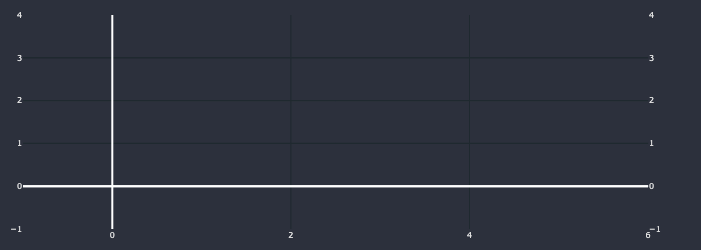

In [97]:
#plot trades and check chart
df_plot = df_slim.iloc[100:150]
#create candle plot
cp = CandlePlot(df_plot, candles=True)

#plot trades ontop where we have a buy or sell returned
trades = cp.df_plot[cp.df_plot.SIGNAL != NONE]

markers = ['mid_c', 'TP', 'SL']
#different colors for each of those 
marker_colors = ['#0000FF', '#00FF00', '#FF0000']

for i in range(3):
    #go thorugh range 
    cp.fig.add_trace(go.Scatter(
        x = trades.sTime, #time
        y = trades[markers[i]], #col we are looping thorug
        mode = 'markers', #set mode in scatter plott we want dots
        marker=dict(color=marker_colors[i], size=12) #make the colors in our color list
    ))

cp.show_plot(line_traces=["EMA_200"], sec_traces=['RSI_14'], height=250)

In [98]:

class Trade:
    #take in row from dataframe
    def __init__(self, row):
        self.running = True #when we start trades its true
        self.start_index = row.name #index of row
        self.start_price = row.mid_c
        self.trigger_price = row.mid_c
        self.SIGNAL = row.SIGNAL
        self.TP = row.TP
        self.SL = row.SL
        self.result = 0.0 
        self.end_time = row.time
        self.start_time = row.time
        self.duration = 0 #how long trades lasted 

    def close_trade(self, row, result, trigger_price):
        self.running = False
        self.result = result
        self.end_time = row.time
        self.trigger_price = trigger_price

    #update using partical row
    def update(self, row):
        self.duration += 1 #duration goes up by 1
        if self.SIGNAL == BUY:
            #we have parameters we set where we want to take loss and profit
            #we will take the profit first if that happens then loss
            if row.mid_h >= self.TP:
                #trade is done complete it and send in other info
                self.close_trade(row, PROFIT_FACTOR, row.mid_h)
            elif row.mid_l <= self.SL:
                self.close_trade(row, LOSS_FACTOR, row.mid_l)
        if self.SIGNAL == SELL:
            if row.mid_l <= self.TP:
                self.close_trade(row, PROFIT_FACTOR, row.mid_l)
            elif row.mid_h >= self.SL:
                self.close_trade(row, LOSS_FACTOR, row.mid_h)    

In [99]:
open_trades = []
closed_trades = []

#itterrows loops and gives back row index and new series 
#when we have a buy or sell signal we will create new instance of it
#and add it to open_trades list and when its closed add it to closed trade list
for index, row in df_slim.iterrows():
    for ot in open_trades:
        #send in our row
        ot.update(row)
        #if trade is no longer running it has trigged take profit or loss and is False
        if ot.running == False:
            #appened to closed trades the trade
            closed_trades.append(ot)
    #add trade into open_trades if running
    open_trades = [x for x in open_trades if x.running == True]

    #if we have a new trade add and create a trade
    if row.SIGNAL != NONE:
        open_trades.append(Trade(row))  #create new trade and add a row  

In [100]:
#create dataframe of trades 
df_results = pd.DataFrame.from_dict([vars(x) for x in closed_trades])

In [103]:
df_results.result.sum()

AttributeError: 'DataFrame' object has no attribute 'result'

In [104]:
df_results.sort_values(by="start_index", inplace=True)

KeyError: 'start_index'

In [105]:
df_m5 = pd.read_pickle("../data/EUR_USD_M5.pkl") #5 min candles

In [106]:
df_m5.shape

(445077, 14)

In [107]:
df_m5.time.max()

Timestamp('2022-12-30 21:55:00+0000', tz='tzutc()')

In [108]:
df_raw.time.max()

Timestamp('2022-12-30 21:00:00+0000', tz='tzutc()')

In [109]:
from dateutil import parser

In [110]:
time_min = parser.parse("2021-12-15T10:00:00Z") #get subset of data within this date time range
time_max = parser.parse("2021-12-15T11:00:00Z")
df_m5_s = df_m5[(df_m5.time>=time_min)&(df_m5.time<=time_max)]
df_raw_s = df_raw[(df_raw.time>=time_min)&(df_raw.time<=time_max)]

In [111]:
df_m5_s #5 min candle

,time,volume,mid_o,mid_h,mid_l,mid_c,bid_o,bid_h,bid_l,bid_c,ask_o,ask_h,ask_l,ask_c
367030,2021-12-15 10:00:00+00:00,208,1.12716,1.12745,1.12709,1.12734,1.12708,1.12738,1.12702,1.12727,1.12723,1.12752,1.12715,1.12742
367031,2021-12-15 10:05:00+00:00,132,1.12733,1.12754,1.12726,1.12746,1.12726,1.12747,1.12719,1.12739,1.12740,1.12760,1.12733,1.12752
367032,2021-12-15 10:10:00+00:00,166,1.12744,1.12752,1.12732,1.12746,1.12737,1.12745,1.12725,1.12739,1.12750,1.12760,1.12739,1.12753
367033,2021-12-15 10:15:00+00:00,138,1.12744,1.12770,1.12740,1.12761,1.12737,1.12763,1.12733,1.12754,1.12752,1.12776,1.12747,1.12768
367034,2021-12-15 10:20:00+00:00,252,1.12760,1.12762,1.12712,1.12712,1.12753,1.12756,1.12705,1.12705,1.12767,1.12769,1.12719,1.12719
367035,2021-12-15 10:25:00+00:00,198,1.12711,1.12726,1.12695,1.12695,1.12704,1.12719,1.12688,1.12688,1.12718,1.12733,1.12702,1.12702
367036,2021-12-15 10:30:00+00:00,142,1.12696,1.12698,1.12680,1.12696,1.12689,1.12691,1.12674,1.12690,1.12703,1.12706,1.12686,1.12703
367037,2021-12-15 10:35:00+00:00,121,1.12698,1.12712,1.12698,1.12700,1.12691,1.12705,1.12691,1.12693,1.12704,1.12718,1.12704,1.12706
367038,2021-12-15 10:40:00+00:00,206,1.12698,1.12707,1.12651,1.12656,1.12692,1.12700,1.12644,1.12649,1.12705,1.12714,1.12658,1.12663
367039,2021-12-15 10:45:00+00:00,165,1.12655,1.12668,1.12645,1.12654,1.12648,1.12661,1.12638,1.12648,1.12662,1.12675,1.12652,1.12661


In [112]:
df_raw_s #1 hour candle

,time,volume,mid_o,mid_h,mid_l,mid_c,bid_o,bid_h,bid_l,bid_c,ask_o,ask_h,ask_l,ask_c
30705,2021-12-15 10:00:00+00:00,2038,1.12716,1.1277,1.12634,1.12673,1.12708,1.12763,1.12627,1.12666,1.12723,1.12776,1.12640,1.12680
30706,2021-12-15 11:00:00+00:00,2138,1.12674,1.1270,1.12626,1.12698,1.12667,1.12693,1.12619,1.12691,1.12681,1.12706,1.12631,1.12705


In [113]:
df_m5_slim = df_m5[['time','mid_h', 'mid_l' ]].copy() #mini dataframe with just these cols

In [114]:
df_m5_slim.head()

,time,mid_h,mid_l
0,2017-01-08 22:00:00+00:00,1.05316,1.05299
1,2017-01-08 22:05:00+00:00,1.05309,1.05307
2,2017-01-08 22:10:00+00:00,1.05312,1.05308
3,2017-01-08 22:15:00+00:00,1.05305,1.05294
4,2017-01-08 22:25:00+00:00,1.05308,1.05295


In [115]:
df_signals = df_slim[df_slim.SIGNAL != NONE].copy()  #new df of just trade signals 

In [116]:
#this dataframe needs timestamp of each signal and add 1 hour to time
df_signals['m5_start'] = [x + dt.timedelta(hours=1) for x in df_signals.time]

In [117]:
df_signals['start_index_h1'] = df_signals.index  #create new colS

In [118]:
df_signals.head()

,time,mid_o,mid_h,mid_l,mid_c,ask_c,bid_c,ENGULFING,direction,EMA_200,RSI_14,SIGNAL,TP,SL,m5_start,start_index_h1


In [119]:
df_signals.columns

Index(['time', 'mid_o', 'mid_h', 'mid_l', 'mid_c', 'ask_c', 'bid_c',
       'ENGULFING', 'direction', 'EMA_200', 'RSI_14', 'SIGNAL', 'TP', 'SL',
       'm5_start', 'start_index_h1'],
      dtype='object')

In [120]:
#remove these cols
df_signals.drop(['time', 'mid_o', 'mid_h', 'mid_l', 'ask_c', 'bid_c',
                'ENGULFING', 'EMA_200', 'RSI_14', 'direction'], axis=1, inplace=True)

In [121]:
df_signals.head()

,mid_c,SIGNAL,TP,SL,m5_start,start_index_h1


In [122]:
#rename col namesS
df_signals.rename(columns={
    'mid_c' : 'start_price',
    'm5_start' : 'time'
}, inplace=True)

In [123]:
df_signals.head(2)

,start_price,SIGNAL,TP,SL,time,start_index_h1


In [124]:
df_m5_slim.head(2)

,time,mid_h,mid_l
0,2017-01-08 22:00:00+00:00,1.05316,1.05299
1,2017-01-08 22:05:00+00:00,1.05309,1.05307


In [164]:
#merge two tables so 5min candle data and signals
#left join 
merged = pd.merge(left=df_m5_slim, right=df_signals, on='time', how='left')

In [165]:
merged.fillna(0, inplace=True) #remove all NA values to 0  values

In [166]:
merged.SIGNAL = merged.SIGNAL.astype(int) #change floats into ints
merged.start_index_h1 = merged.start_index_h1.astype(int)

In [167]:
merged.head()

,time,mid_h,mid_l,start_price,SIGNAL,TP,SL,start_index_h1
0,2017-01-08 22:00:00+00:00,1.05316,1.05299,0.0,0,0.0,0.0,0
1,2017-01-08 22:05:00+00:00,1.05309,1.05307,0.0,0,0.0,0.0,0
2,2017-01-08 22:10:00+00:00,1.05312,1.05308,0.0,0,0.0,0.0,0
3,2017-01-08 22:15:00+00:00,1.05305,1.05294,0.0,0,0.0,0.0,0
4,2017-01-08 22:25:00+00:00,1.05308,1.05295,0.0,0,0.0,0.0,0


In [ ]:
#same class as before justs 5 min candles
class TradeM5:
    def __init__(self, row):
        self.running = True
        self.start_index_m5 = row.name
        self.start_index_h1 = row.start_index_h1
        self.start_price = row.start_price
        self.trigger_price = row.start_price
        self.SIGNAL = row.SIGNAL
        self.TP = row.TP
        self.SL = row.SL
        self.result = 0.0
        self.end_time = row.time
        self.start_time = row.time
        self.duration = 1
        
    def close_trade(self, row, result, trigger_price):
        self.running = False
        self.result = result
        self.end_time = row.time
        self.trigger_price = trigger_price
        
    def update(self, row):
        self.duration += 1
        if self.SIGNAL == BUY:
            if row.mid_h >= self.TP:
                self.close_trade(row, PROFIT_FACTOR, row.mid_h)
            elif row.mid_l <= self.SL:
                self.close_trade(row, LOSS_FACTOR, row.mid_l)
        if self.SIGNAL == SELL:
            if row.mid_l <= self.TP:
                self.close_trade(row, PROFIT_FACTOR, row.mid_l)
            elif row.mid_h >= self.SL:
                self.close_trade(row, LOSS_FACTOR, row.mid_h)   

In [ ]:
#same as before just 5 min candle
open_trades_m5 = []
closed_trades_m5 = []

for index, row in merged.iterrows():       
    for ot in open_trades_m5:
        ot.update(row)
        if ot.running == False:
            closed_trades_m5.append(ot)
    open_trades_m5 = [x for x in open_trades_m5 if x.running == True]

    if row.SIGNAL != NONE:
        open_trades_m5.append(TradeM5(row))   
    

In [ ]:
len(closed_trades_m5)

In [ ]:

df_res_m5 = pd.DataFrame.from_dict([vars(x) for x in closed_trades_m5])

In [ ]:
df_res_m5.head()

In [156]:
df_res_m5.result.sum()

AttributeError: 'DataFrame' object has no attribute 'result'